Let's see if we can create a model to predict if a coin will
1. go up by 1%
2. trade in the same zone
3. go down by 1%
in the next 2 hours (12 5m candles)

on CDC exchange, fees are 0.4% per transaction, so we should aim to make at least 0.2% profit on each trade

In [7]:
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpl
from sklearn.preprocessing import MinMaxScaler
from ta.momentum import rsi
from ta.trend import sma_indicator


from cdc_wrapper import CDC

In [2]:
with open('keys.json', 'r') as f:
    keys = json.load(f)

cdc = CDC(keys, sandbox=False)

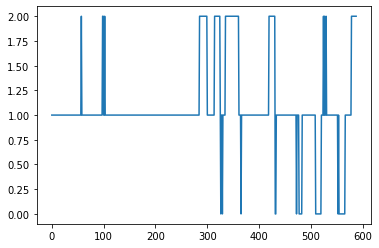

In [44]:
data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)

df = pd.DataFrame.from_records(data)

future_window = 12
future_diff_threshold = 0.012

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold

df['label'] = 1
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 0
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 1

df = df[['c', 'label']]

y = df['label'].values

plt.plot(y)

Let's focus on ETH USDC

In [5]:
data_file_name = 'data2.csv'
instrument = 'BTC_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

# technical analysis params
rsi_windows = [5, 7]
sma_windows = [5, 8, 13]

# load in and drop duplicates
df = pd.read_csv(data_file_name).drop_duplicates()

# we are streaming data in through the websocket so we only need the latest row 
df = df.groupby(['instrument', 't']).last().reset_index()

# filter for ETH USDC
df = df.loc[df['instrument']==instrument]

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold



df['label'] = 0
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 1
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 0

# now that we have the labels, we can remove the future values and clean up a bit...

df = df[['dt', 'o', 'h', 'l', 'c', 'v', 'label']]

df = df.set_index('dt')

for w in rsi_windows:
    df[f'rsi{w}'] = rsi(df['c'], window=w)

for w in sma_windows:
    df[f'sma{w}'] = sma_indicator(df['c'], window=w)



X_cols = [col for col in df.columns if col != 'label']
# # let's bring in the past values

for i in range(1, past_window+1):
    for col in X_cols:
        df[f'{col}_{i}'] = df[col].shift(i)


# drop rows with NAs i.e. those that maybe be missing some indicators (due to the window) or past data
df = df.dropna()


# scaler = MinMaxScaler()
# X = df.drop(['dt', 'label'], axis=1).values
# y = df['label'].values

# scaler.fit(X)

# scaler.transform(X)

df

C:\Users\cetyz\AppData\Local\Temp\ipykernel_29256\623405285.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{i}'] = df[col].shift(i)
C:\Users\cetyz\AppData\Local\Temp\ipykernel_29256\623405285.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{i}'] = df[col].shift(i)
C:\Users\cetyz\AppData\Local\Temp\ipykernel_29256\623405285.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

,o,h,l,c,v,label,rsi5,rsi7,sma5,sma8,...,o_24,h_24,l_24,c_24,v_24,rsi5_24,rsi7_24,sma5_24,sma8_24,sma13_24
dt,,,,,,,,,,,,,,,,,,,,,
2022-07-09 08:35:00,21645.49,21661.70,21639.29,21656.35,0.510084,0,59.820762,58.852986,21637.192,21634.36000,...,21514.19,21526.27,21506.00,21515.04,0.334715,60.183194,60.012092,21511.904,21505.47750,21502.113077
2022-07-09 08:40:00,21655.66,21670.35,21623.69,21664.65,0.472203,0,63.163305,61.232828,21651.000,21639.52875,...,21520.13,21548.59,21516.55,21533.31,0.827951,72.495962,69.933427,21516.222,21511.32375,21505.446923
2022-07-09 08:45:00,21665.22,21717.34,21658.84,21689.57,0.383206,0,71.927875,67.763706,21662.048,21647.89625,...,21534.59,21552.09,21525.49,21537.91,2.348366,74.935346,71.975825,21520.214,21516.40500,21508.640769
2022-07-09 08:50:00,21688.30,21701.91,21647.83,21701.24,0.795591,0,75.359725,70.480668,21670.416,21655.17750,...,21540.09,21554.94,21537.29,21543.55,0.588047,77.934683,74.457723,21529.420,21521.78625,21511.536923
2022-07-09 08:55:00,21696.67,21715.14,21680.83,21704.79,0.880061,0,76.454268,71.338000,21683.320,21668.82500,...,21546.85,21560.32,21538.68,21546.70,0.769490,79.635938,75.851277,21535.302,21526.15875,21515.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12 06:30:00,19871.23,19909.05,19864.72,19899.07,1.092117,1,46.983600,44.129491,19887.418,19889.48375,...,19986.62,20019.07,19965.51,19972.97,0.719943,74.315204,71.888243,19965.156,19950.19875,19933.196154
2022-07-12 06:35:00,19886.57,19897.77,19850.47,19856.08,0.180033,1,35.203790,35.622932,19883.288,19879.26875,...,19974.04,19977.39,19952.01,19958.23,0.351921,55.583924,58.932820,19967.400,19954.27500,19937.970769
2022-07-12 06:40:00,19839.02,19904.77,19837.23,19880.71,0.724150,1,45.067270,42.970870,19878.748,19875.18625,...,19961.19,19992.49,19958.78,19983.76,0.720944,71.264730,69.895658,19973.972,19962.17000,19945.003846


will need to kfold because rows near to each other might be highly correlated??

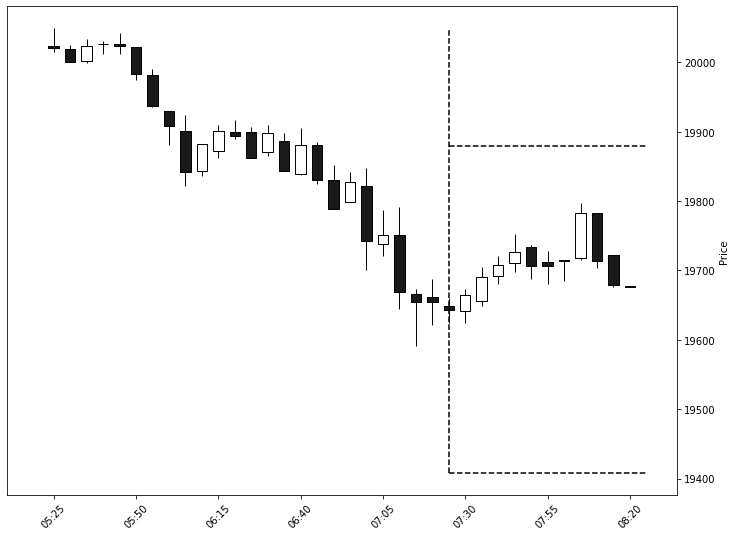

In [32]:
testing_data = cdc.get_candlesticks(instrument_name=instrument, time_frame='5m', depth=future_window+past_window)

testing_df = pd.DataFrame.from_records(testing_data)

testing_df['dt'] = pd.to_datetime(testing_df['t'], unit='ms')

testing_df = testing_df.drop('t', axis=1).set_index('dt').rename({'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12,9))

mpl.plot(
    testing_df,
    type='candle',
    style='classic',
    ax=ax
)

plt.sca(ax)

vline_y_min = min(testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), testing_df['Low'].min())
vline_y_max = max(testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), testing_df['High'].max())

plt.vlines(x=past_window, ymin=vline_y_min, ymax=vline_y_max, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')

plt.show()